# Visualisation des données de la campagne "visite panier" de l'annonceur 2

## Visualisation des données brutes

In [1]:
# fichiers contenant les fonctions utiles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
from part1 import *
from part2 import *
from part3 import *

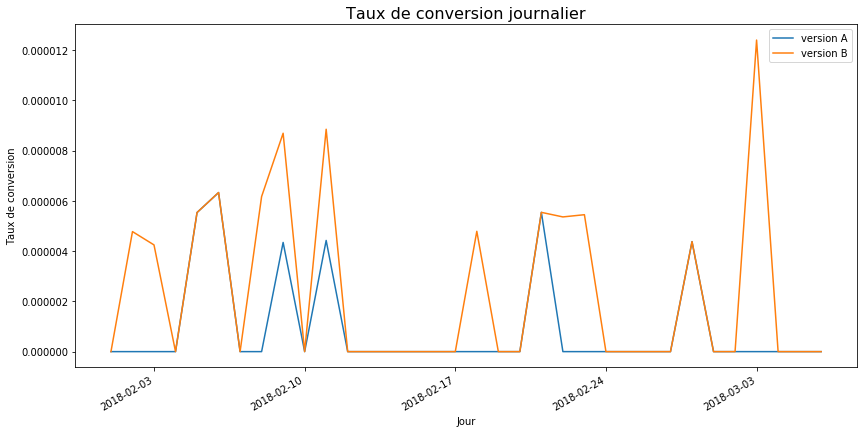

In [2]:
datasetA = pd.read_hdf('/Users/guillaumeshi/PycharmProjects/1000mercis/Data/annonceur2/annonceur2_daily.hdf', key='visite_panierA')
datasetB = pd.read_hdf('/Users/guillaumeshi/PycharmProjects/1000mercis/Data/annonceur2/annonceur2_daily.hdf', key='visite_panierB')
plt.rcParams["figure.figsize"] = (14,7)
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot_date(datasetA.index, datasetA['conv_rate'], marker='', linestyle='-')
plt.plot(datasetA.index, datasetB['conv_rate'])
plt.xlabel('Jour')
plt.ylabel('Taux de conversion')
plt.title('Taux de conversion journalier', fontsize=16)
plt.legend(['version A', 'version B'], loc='best')
plt.show()

La version B semble ainsi plus efficace que la version A dans la mesure où les taux de conversion sont toujours supérieurs ou égaux à ceux de la version A. Il reste à voir si cette observation est statistiquement significative, d'où la nécessité d'un test d'hypothèses.

## Différence relative des taux de conversion

Dans le cadre de cette campagne, étudier la différence relative journalière des taux de conversion s'avère compliqué. En effet, les taux de conversions sont régulièrement nuls (presque la moitié du temps pour les deux versions A et B), si bien que le calcul d'une différence relative d'un point de vue quotidien ne fait pas beaucoup de sens. En revanche, une agrégation des données à une maille hebdomadaire permet de mieux visualiser cette différence relative.

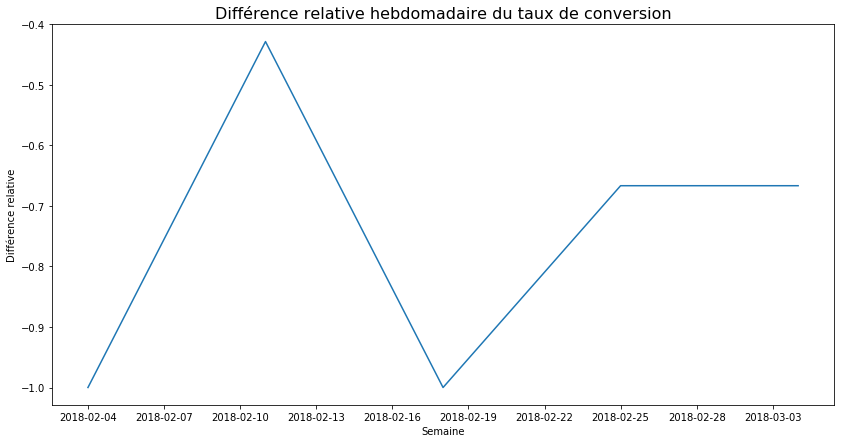

In [3]:
weekly_datasetA = datasetA.resample('W').sum()
weekly_datasetA['conv_rate'] = weekly_datasetA['n_convs'] / weekly_datasetA['total_impressions']

weekly_datasetB = datasetB.resample('W').sum()
weekly_datasetB['conv_rate'] = weekly_datasetB['n_convs'] / weekly_datasetB['total_impressions']

weekly_relative_difference = (weekly_datasetA - weekly_datasetB) / weekly_datasetB

plt.rcParams["figure.figsize"] = (14,7)
plt.plot(weekly_relative_difference.index, weekly_relative_difference['conv_rate'])
plt.xlabel('Semaine')
plt.ylabel('Différence relative')
plt.title('Différence relative hebdomadaire du taux de conversion', fontsize=16)
plt.show()

Il apparaît ainsi que d'un point de vue hebdomadaire, la différence relative était toujours négative, c'est-à-dire que **la version A suscitait un taux de conversion toujours inférieur à celui engendré par la version B**.

# Analyse des données de la campagne "visite panier" de l'annonceur 2

## Stationnarité des données

On s'intéresse dans un premier temps à la stationnarité des données : le taux de conversion dépend-t-il du jour de la visite ? Y a-t-il des jours où le taux de conversion semble influencer la conversion des utilisateurs ?

In [4]:
adf_test(datasetA['conv_rate'])

,Results of Augmented Dickey-Fuller test:
test statistic,-5.287447
p-value,0.000006
# of lags,0.000000
# of observations,33.000000
Critical Value (1%),-3.646135
Critical Value (5%),-2.954127
Critical Value (10%),-2.615968


In [5]:
adf_test(datasetB['conv_rate'])

,Results of Augmented Dickey-Fuller test:
test statistic,-6.159365e+00
p-value,7.236679e-08
# of lags,0.000000e+00
# of observations,3.300000e+01
Critical Value (1%),-3.646135e+00
Critical Value (5%),-2.954127e+00
Critical Value (10%),-2.615968e+00


Un test de Dickey-Fuller sur la série temporelle des taux de conversions journaliers pour la version A indique que celle-ci est stationnaire (p-value inférieure à 1%). De même, la série temporelle pour la version B indique que celle-ci est stationnaire.

## Saisonnalité des données

On essaie ensuite de voir si de la série temporelle on peut dégager certaines tendances : tendance globale, composante saisonnière et résidu, le but étant de voir si les taux de conversion peuvent être affectés par certains cycles temporels, et, le cas échéant, dans quelle mesure. Puisque nous travaillons avec des taux de conversion dont les valeurs peuvent être nulles, on se focalisera essentiellement sur des modèles additifs.

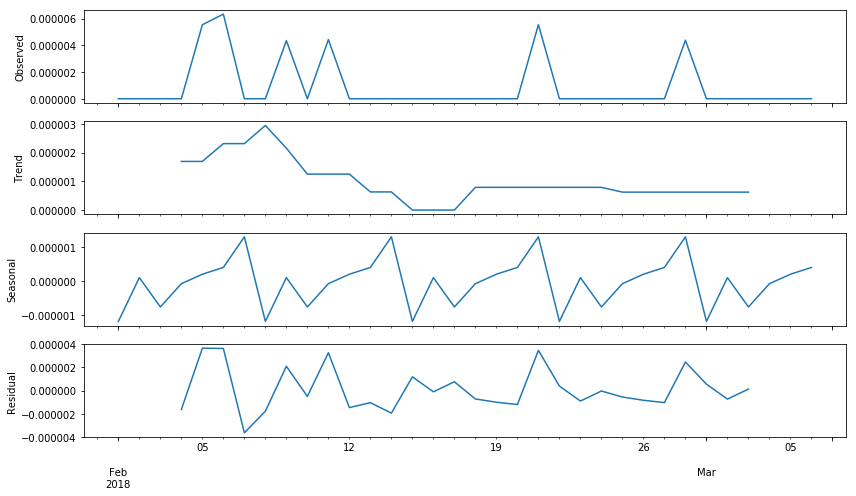

In [6]:
conversion_rate = datasetA['conv_rate']
conversion_rate.index = pd.to_datetime(conversion_rate.index)
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(conversion_rate, model="additive")
plt.rcParams["figure.figsize"] = (12,7)
decomposition.plot()
plt.show()

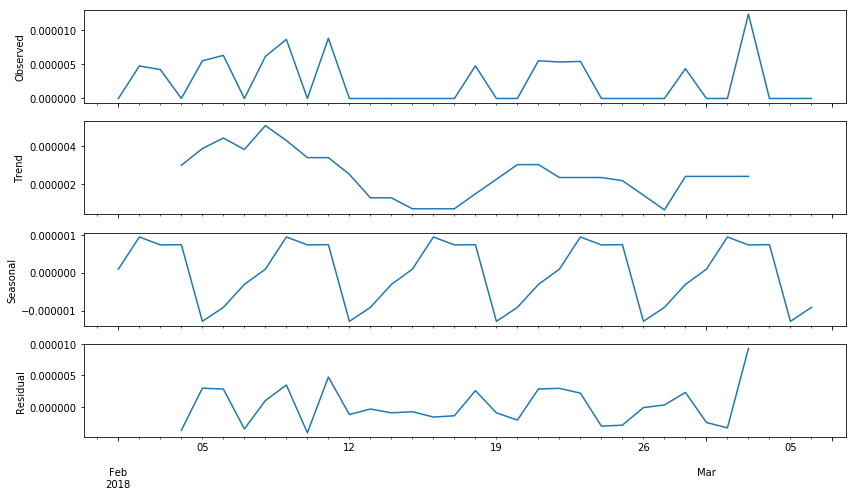

In [7]:
conversion_rate = datasetB['conv_rate']
conversion_rate.index = pd.to_datetime(conversion_rate.index)
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(conversion_rate, model="additive")
plt.rcParams["figure.figsize"] = (12,7)
decomposition.plot()
plt.show()

# Z-test : conclusion quant à l'efficacité du test A/B mené

## Z-test global

Enfin, on conduit un Z-test destiné à mesure l'efficacité statistique du test A/B mené. Mathématiquement, cela se traduit par la comparaison de l'hypothèse nulle H0 : "le taux de conversion sous version A est le même que celui sous version B" avec l'hypothèse H1 : "le taux de conversion sous version A est différent que celui sous version B". En d'autres termes, l'hypothèse H1 traduit le fait que la version B a bel et bien une influence sur le taux de conversion.

In [8]:
from scipy.stats import norm
pA = sum(datasetA['n_convs']) / sum(datasetA['total_impressions'])
pB = sum(datasetB['n_convs']) / sum(datasetB['total_impressions'])

nA = sum(datasetA['total_impressions'])
nB = sum(datasetB['total_impressions'])

Z_value = (pA - pB) / np.sqrt(pA * (1 - pA) / nA + pB * (1 - pB) / nB)
p_val = 1 - norm.cdf(abs(Z_value)) + norm.cdf(-abs(Z_value))

print(p_val)

0.033006072084115004


On obtient une p-valeur inférieure aux seuils usuels de 10% et 5%. On rejette donc l'hypothèse H0 et on en déduit alors que **la version B semble avoir plus d'influence sur le taux de conversion que la version A. En effet, comme vu précédemment, les taux de conversion sous version B sont supérieurs à ceux sous la version A.**

## Z-test cumulé (pas journalier)

On s'intéresse maintenant aux **données cumulées** : en regardant l'ensemble des informations dont on dispose du jour 1 de la campagne publicitaire au jour n, peut-on voir une certaine tendance quant au test d'hypothèses ?

/Users/guillaumeshi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


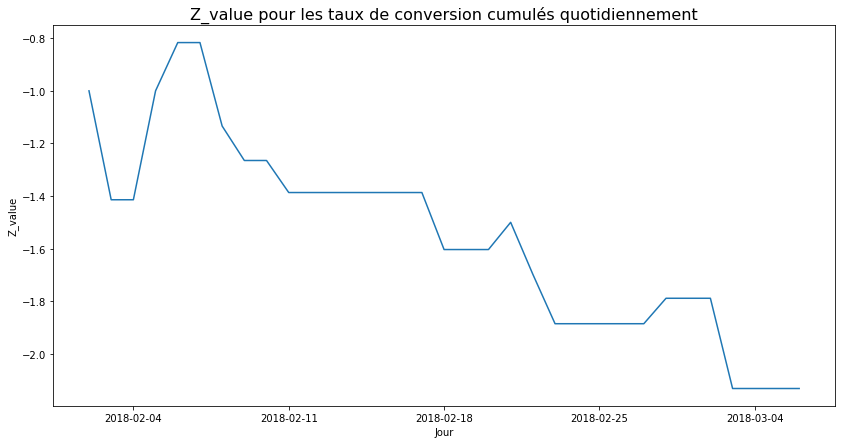

In [9]:
daily_cumsum_datasetA = datasetA[['total_impressions', 'n_convs']].cumsum()
daily_cumsum_datasetB = datasetB[['total_impressions', 'n_convs']].cumsum()
daily_cumsum_datasetA['conv_rate'] = daily_cumsum_datasetA['n_convs'] / daily_cumsum_datasetA['total_impressions']
daily_cumsum_datasetB['conv_rate'] = daily_cumsum_datasetB['n_convs'] / daily_cumsum_datasetB['total_impressions']

Z_value = []
p_value = []

for date in daily_cumsum_datasetA.index:
    pA = daily_cumsum_datasetA.loc[date]['conv_rate']
    nA = daily_cumsum_datasetA.loc[date]['total_impressions']
    pB = daily_cumsum_datasetB.loc[date]['conv_rate']
    nB = daily_cumsum_datasetB.loc[date]['total_impressions']
    Z_value.append((pA-pB)/np.sqrt(pA*(1-pA)/nA + pB*(1-pB)/nB))
    p_value.append(1 - norm.cdf(abs(Z_value[-1])) + norm.cdf(-abs(Z_value[-1])))

        
plt.rcParams["figure.figsize"] = (14,7)
plt.plot(daily_cumsum_datasetA.index, Z_value)
plt.xlabel('Jour')
plt.ylabel('Z_value')
plt.title('Z_value pour les taux de conversion cumulés quotidiennement', fontsize=16)
plt.show()

La Z-value est toujours positive. Cette valeur était du signe de la différence entre le taux de conversion sous version A et celui sous version B, cela nous indique qu'a priori, la version A était meilleure que la version B. Il reste à voir si cela peut être confirmé ou infirmé statistiquement. On s'intéresse ainsi à l'évoluation de la p-valeur.

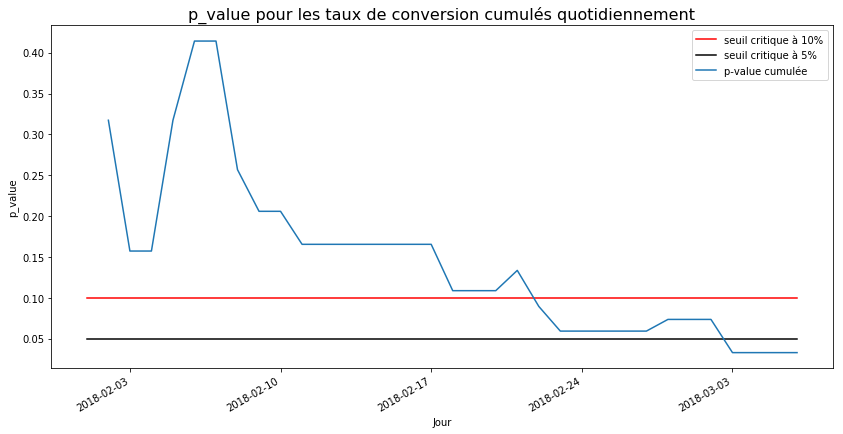

In [10]:
plt.rcParams["figure.figsize"] = (14,7)

fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot_date(datasetA.index, [0.1]*len(datasetA.index), marker='', linestyle='-', c='red')
ax.plot_date(datasetA.index, [0.05]*len(datasetA.index), marker='', linestyle='-', c='black')
plt.plot(daily_cumsum_datasetA.index, p_value)
plt.xlabel('Jour')
plt.ylabel('p_value')
plt.title('p_value pour les taux de conversion cumulés quotidiennement', fontsize=16)
plt.legend(['seuil critique à 10%', 'seuil critique à 5%', 'p-value cumulée'], loc='best')
plt.show()

On voit ainsi que la p-value cumulée se situe au-delà du seuil critique à 5% jusqu'au 3 mars 2018 environ, soit approximativement la fin de la campagne. En d'autres termes, l'hypothèse nulle "la version B n'a pas plus d'influence que la version A sur le taux de conversion" aurait été acceptée si la campagne avait pris fin avant le 3 mars. Néanmoins, en prenant une vue globale de la campagne après cette date, on s'aperçoit qu'il convient finalement de rejeter l'hypothèse nulle, et d'en déduire que la version B est en réalité meilleure que la version A. **Cela tient notamment au fait que la version B a enregistré un grand nombre de conversions le jour du 3 mars**, changeant ainsi significativement la p-value.

Avec une significativité à 10%, la ligne rouge aurait été à 0,1. La courbe bleue représentant la p-value cumulée serait passée en-deçà de ce seuil critique à la date du 22 février. Autrement dit, **si l'on s'était fixé un seuil de confiance à 10% pour accepter l'hypothèse selon laquelle la version B était meilleure que la version A, cette hypothèse aurait été acceptée à la date du 21 février**, contrairement au seuil de confiance de 5% qui nous aurait amené à attendre le 3 mars.

## Z-test cumulé (pas de 3 jours)

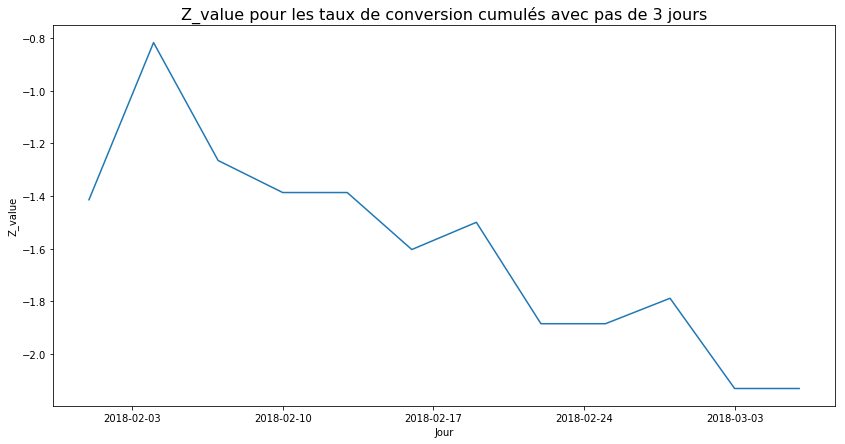

In [11]:
def cumulated_dataset_freq(dataset, frequency):  # dataset cumulé avec un pas de frequency jours
    cumulated_dataset = dataset.resample(frequency).sum().cumsum()
    cumulated_dataset['conv_rate'] = cumulated_dataset['n_convs'] / cumulated_dataset['total_impressions']
    return cumulated_dataset

frequency = '3D'

cumulated_datasetA = cumulated_dataset_freq(datasetA, frequency)
cumulated_datasetB = cumulated_dataset_freq(datasetB, frequency)

Z_value = []
p_value = []

for date in cumulated_datasetA.index:
    pA = cumulated_datasetA.loc[date]['conv_rate']
    nA = cumulated_datasetA.loc[date]['total_impressions']
    pB = cumulated_datasetB.loc[date]['conv_rate']
    nB = cumulated_datasetB.loc[date]['total_impressions']
    Z_value.append((pA-pB)/np.sqrt(pA*(1-pA)/nA + pB*(1-pB)/nB))
    p_value.append(1 - norm.cdf(abs(Z_value[-1])) + norm.cdf(-abs(Z_value[-1])))
    
plt.rcParams["figure.figsize"] = (14,7)
plt.plot(cumulated_datasetA.index, Z_value)
plt.xlabel('Jour')
plt.ylabel('Z_value')
plt.title(f'Z_value pour les taux de conversion cumulés avec pas de {frequency[0]} jours', fontsize=16)
plt.show()

L'évolution de la Z-value est ainsi similaire à celle trouvée avec un pas quotidien. En effet, en prenant une fenêtre temporelle plus large pour regarder le cumul des données, on obtient une courbe plus lissée car celle-ci agrège les données à un plus haut niveau. L'allure reste toutefois semblable à celle où la fenêtre est plus réduite (et donc plus précise). Intéressons maintenant l'évolution de la p-value : **une fenêtre temporelle de 3 jours pour le cumul des données change-t-il la significativité du test, et donc la conclusion finale ?**

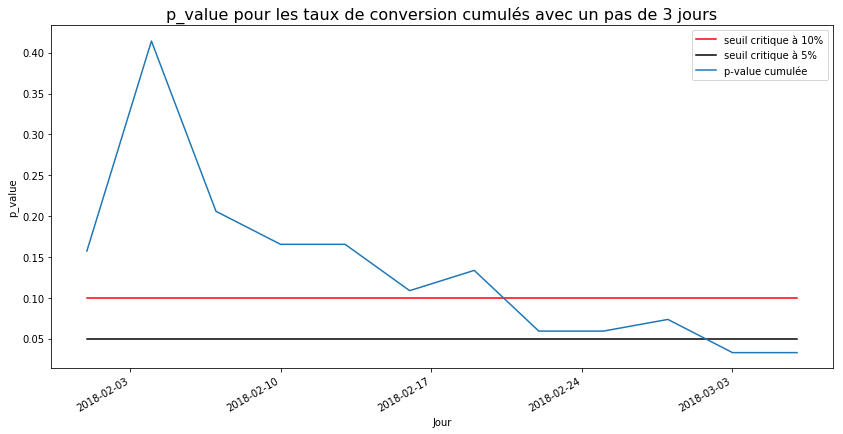

In [12]:
plt.rcParams["figure.figsize"] = (14,7)

fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot_date(cumulated_datasetA.index, [0.1]*len(cumulated_datasetA.index), marker='', linestyle='-', c='red')
ax.plot_date(cumulated_datasetA.index, [0.05]*len(cumulated_datasetA.index), marker='', linestyle='-', c='black')
plt.plot(cumulated_datasetA.index, p_value)
plt.xlabel('Jour')
plt.ylabel('p_value')
plt.title(f'p_value pour les taux de conversion cumulés avec un pas de {frequency[0]} jours', fontsize=16)
plt.legend(['seuil critique à 10%', 'seuil critique à 5%', 'p-value cumulée'], loc='best')
plt.show()

Là encore, la p-value cumulée se comporte de manière similaire : hausse jusqu'au 4 février puis chute jusqu'à la fin de la campagne. En revanche, un niveau d'agrégation des données de 3 jours change légèrement la date à laquelle les conclusions sont significativement recevables. En effet, pour le seuil critique à 10%, on peut affirmer dès le 20 février que la version A est meilleure que la version B. Pour le seuil critique à 5%, on peut l'affirmer dès le 2 mars. Ainsi, **avec un regroupement des données par "paquets" de 3 jours, on peut établir que la version A est meilleure que la version B en moyenne un jour plus tôt que si les données étaient observées quotidiennement**.